important libraries

In [1]:
!pip install vaderSentiment
!pip install tabulate
!pip install textblob
!pip install datasets
!pip install transformers
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.6 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np                    # For numerical operations
import pandas as pd                   # For data manipulation and analysis
import matplotlib.pyplot as plt       # For plotting and visualizing data
import seaborn as sns                 # For statistical data visualization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from tabulate import tabulate
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import RandomizedSearchCV


device name

loading the dataset

In [4]:
import pandas as pd
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Dricz/515k-Hotel-Reviews-In-Europe")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Save as CSV
df.to_csv("hotel_reviews_train.csv", index=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Hotel_Reviews.csv:   0%|          | 0.00/238M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/515738 [00:00<?, ? examples/s]

In [5]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("hotel_reviews_train.csv")

# Display the first few rows
print(df.head())

# Display basic information about the dataset
print(df.info())


                                       Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                     

In [6]:
print(tabulate(df.head(10), headers='keys', tablefmt='pretty'))

+---+----------------------------------------------------------+------------------------------+-------------+---------------+-------------+----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

checking if any null values exist

In [7]:
print(df.isnull().sum())

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64


dropping the null values

In [8]:
df_cleaned = df.dropna()

checking for the duplicate values

In [9]:
print("duplicate rows: ", df_cleaned.duplicated().sum())

duplicate rows:  526


dropping the duplicate values

In [10]:
df_cleaned.drop_duplicates()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/30/2015,8.1,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,14,2823,location,2,8,7.0,"[' Leisure trip ', ' Family with older childre...",704 day,48.203745,16.335677
515734,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/22/2015,8.1,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,11,2823,Breakfast was ok and we got earlier check in,11,12,5.8,"[' Leisure trip ', ' Family with young childre...",712 day,48.203745,16.335677
515735,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/19/2015,8.1,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,19,2823,No Positive,0,3,2.5,"[' Leisure trip ', ' Family with older childre...",715 day,48.203745,16.335677
515736,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/17/2015,8.1,Atlantis Hotel Vienna,Mexico,No Negative,0,2823,The rooms are enormous and really comfortable...,25,3,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",717 day,48.203745,16.335677


encoding for converting nono numeric columns into numeric

In [11]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the CSV file
df = pd.read_csv("hotel_reviews_train.csv")

# Display basic information about the dataset
print(df.info())

# Display missing values count
print(df.isnull().sum())

# Fill missing values instead of dropping entire rows (prevents data loss)
df.fillna({'Negative_Review': "No Negative", 'Positive_Review': "No Positive"}, inplace=True)

# Drop remaining rows with critical missing values (e.g., missing hotel name, score)
df_cleaned = df.dropna()

# Drop duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Step 1: Identify non-numeric columns (excluding text review columns)
text_columns = ['Negative_Review', 'Positive_Review']
non_numeric_columns = df_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric_columns = [col for col in non_numeric_columns if col not in text_columns]  # Exclude text columns

# Step 2: Apply Label Encoding for categorical columns
label_encoder = LabelEncoder()

for column in non_numeric_columns:
    df_cleaned[column] = label_encoder.fit_transform(df_cleaned[column])

# Step 3: Convert text columns (Negative_Review and Positive_Review) using Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    text = str(text).strip().lower()

    # Handle placeholder values ("No Negative", "No Positive")
    if text in ["no negative", "no positive", ""]:
        return 0  # Neutral sentiment

    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Compound sentiment score (-1 to 1)

# Apply sentiment analysis
df_cleaned['Negative_Review'] = df_cleaned['Negative_Review'].apply(get_vader_sentiment)
df_cleaned['Positive_Review'] = df_cleaned['Positive_Review'].apply(get_vader_sentiment)

# Check the changes
print(df_cleaned.head())

# Optionally, save the cleaned and transformed dataset
df_cleaned.to_csv('hotel_reviews_cleaned.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [12]:
# Display the first 100 rows of the transformed dataset with side-by-side view
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set width to avoid truncation
pd.set_option('display.max_rows', 1000)        # Display only the first 100 rows

# Show the first 5 rows of the transformed DataFrame
print(df_cleaned.head(1000))

     Hotel_Address  Additional_Number_of_Scoring  Review_Date  Average_Score  Hotel_Name  Reviewer_Nationality  Negative_Review  Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  Positive_Review  Review_Total_Positive_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score   Tags  days_since_review        lat       lng
0                0                           194          654            7.7         560                   167          -0.9435                                397                     1403           0.5994                                 11                                           7             2.9  19958                  0  52.360576  4.915968
1                0                           194          654            7.7         560                    98           0.0000                                  0                     1403           0.9603                                105                                           7             7.5  19954

In [13]:
# Check the shape of the dataset
print(f"Dataset contains {df_cleaned.shape[0]} rows and {df_cleaned.shape[1]} columns.")


Dataset contains 511944 rows and 17 columns.


univariate analysis:

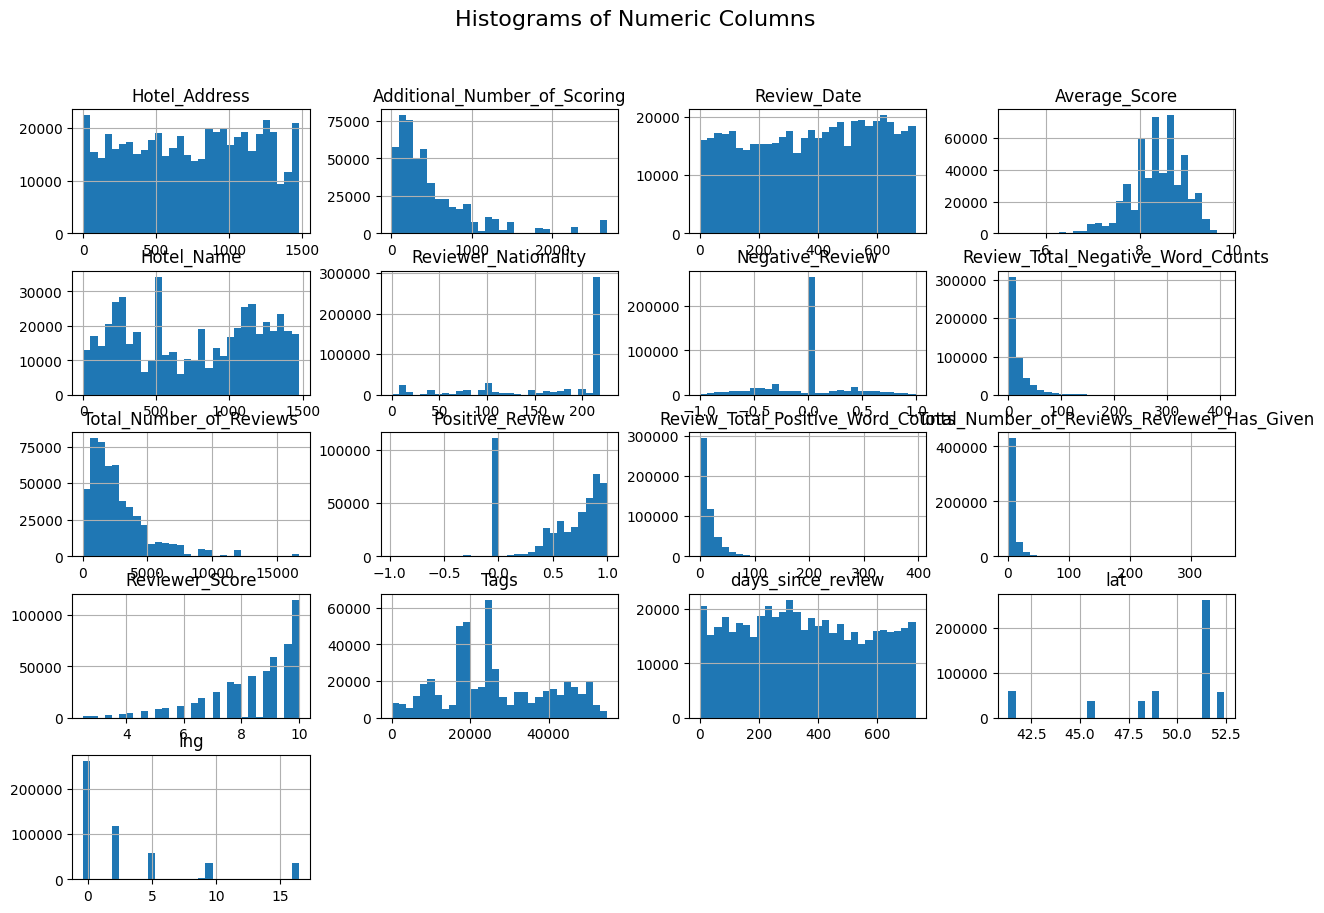

In [14]:

# Plot histograms for numeric columns
df_cleaned.hist(figsize=(15, 10), bins=30)
plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.show()


sentiment analysis distribution

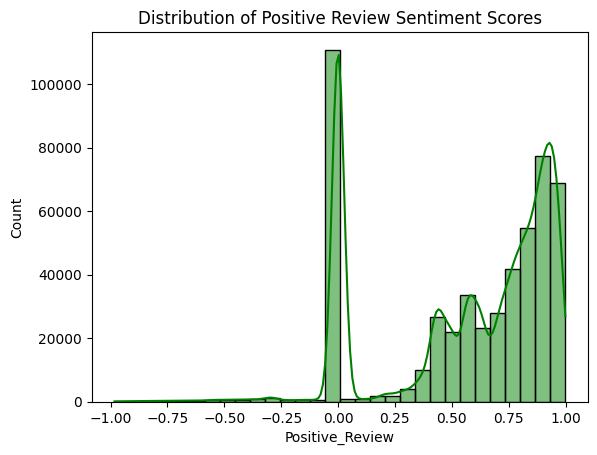

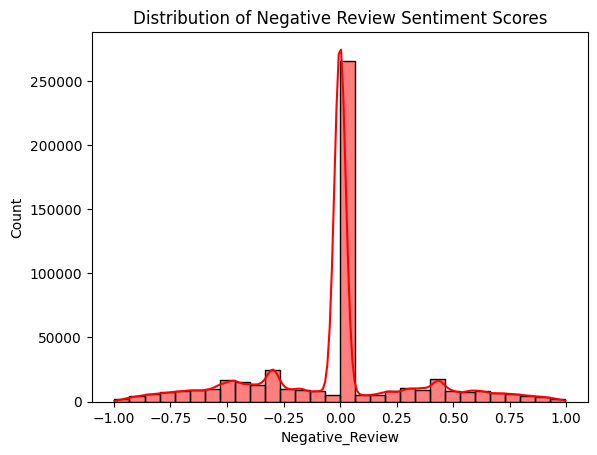

In [15]:
# Plot distributions for Positive_Review and Negative_Review sentiment scores
sns.histplot(df_cleaned['Positive_Review'], kde=True, bins=30, color='green')
plt.title("Distribution of Positive Review Sentiment Scores")
plt.show()

sns.histplot(df_cleaned['Negative_Review'], kde=True, bins=30, color='red')
plt.title("Distribution of Negative Review Sentiment Scores")
plt.show()


catagorical column analysis

In [16]:
# Countplots for encoded categorical columns
categorical_columns = df_cleaned.select_dtypes(include=['int64', 'category']).columns
for col in categorical_columns:
    if df_cleaned[col].nunique() < 20:  # For columns with fewer unique values
        sns.countplot(y=df_cleaned[col], order=df_cleaned[col].value_counts().index)
        plt.title(f"Countplot for {col}")
        plt.show()


Bivariate Analysis: Correlation Matrix

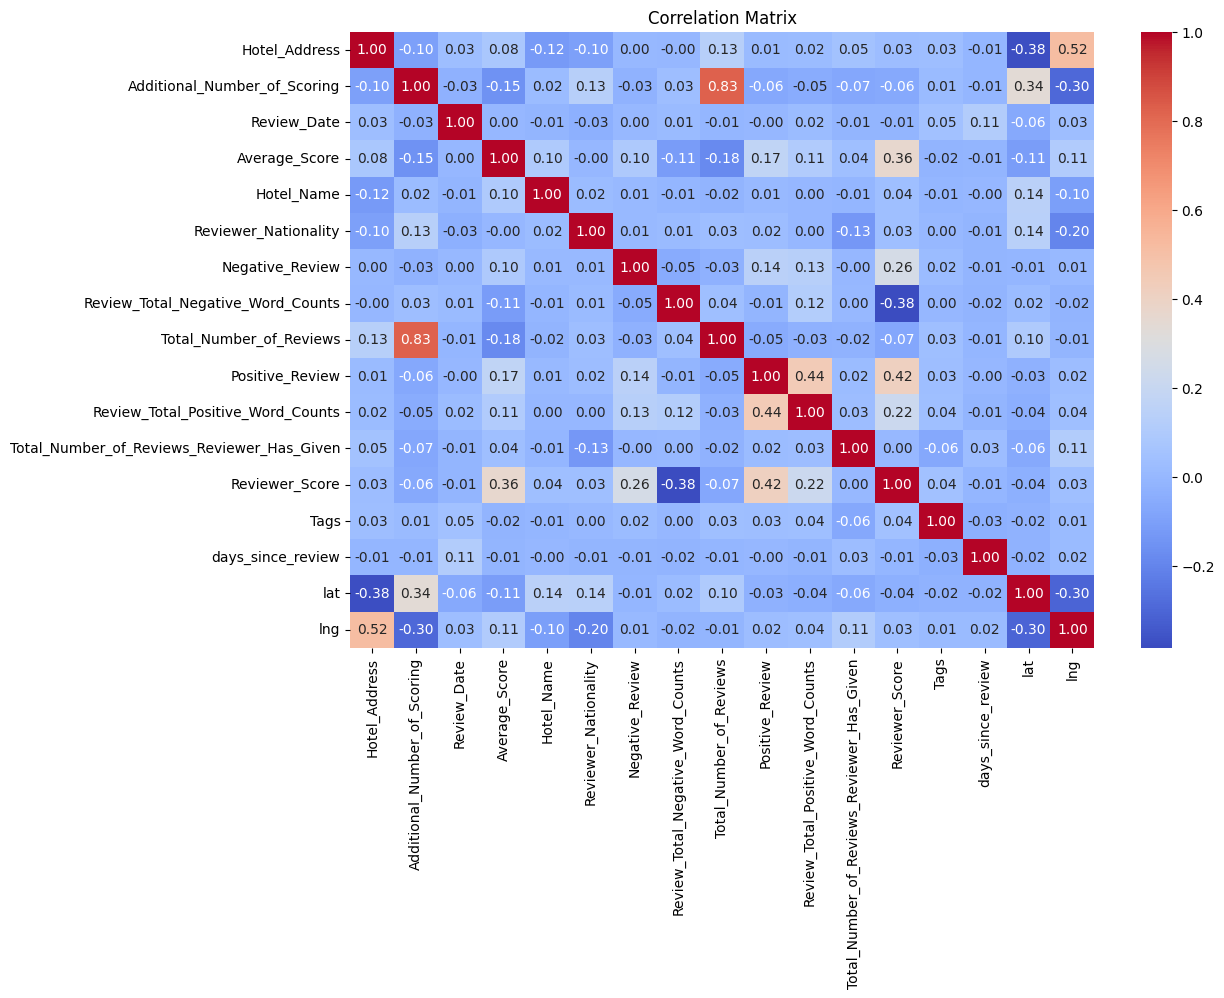

In [17]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Scatterplots for Key Relationships:

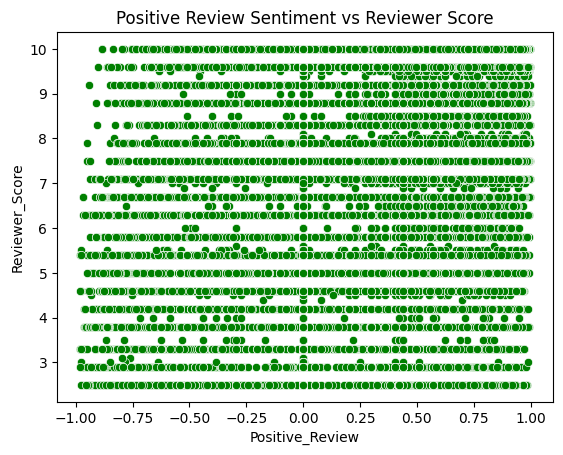

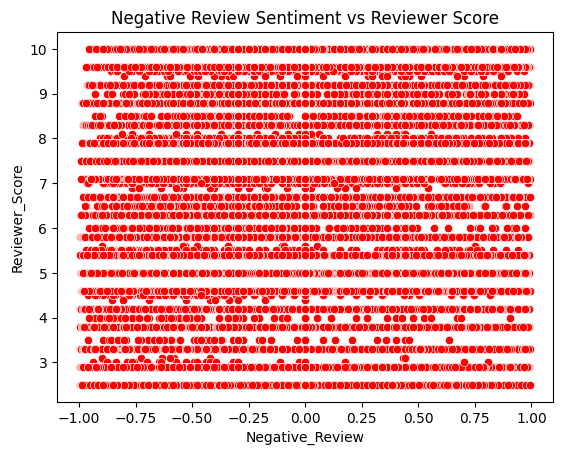

In [18]:
# Scatterplots for sentiment vs Reviewer Score
sns.scatterplot(x='Positive_Review', y='Reviewer_Score', data=df_cleaned, color='green')
plt.title("Positive Review Sentiment vs Reviewer Score")
plt.show()

sns.scatterplot(x='Negative_Review', y='Reviewer_Score', data=df_cleaned, color='red')
plt.title("Negative Review Sentiment vs Reviewer Score")
plt.show()


boxplot for target distribution

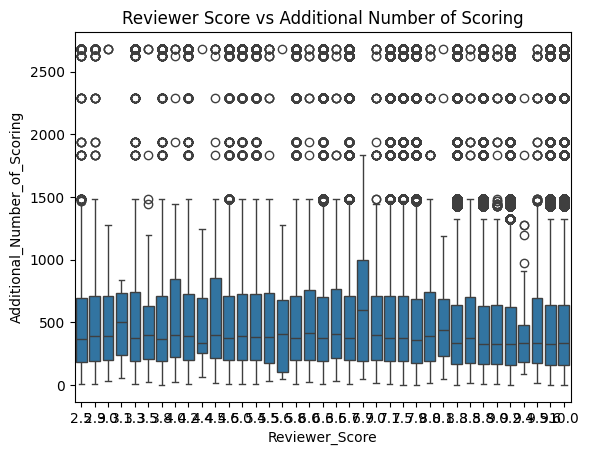

In [19]:
# Boxplots for Reviewer_Score across a categorical column
sns.boxplot(x='Reviewer_Score', y='Additional_Number_of_Scoring', data=df_cleaned)
plt.title("Reviewer Score vs Additional Number of Scoring")
plt.show()


Multivariate Analysis: Pairplots for Relationships

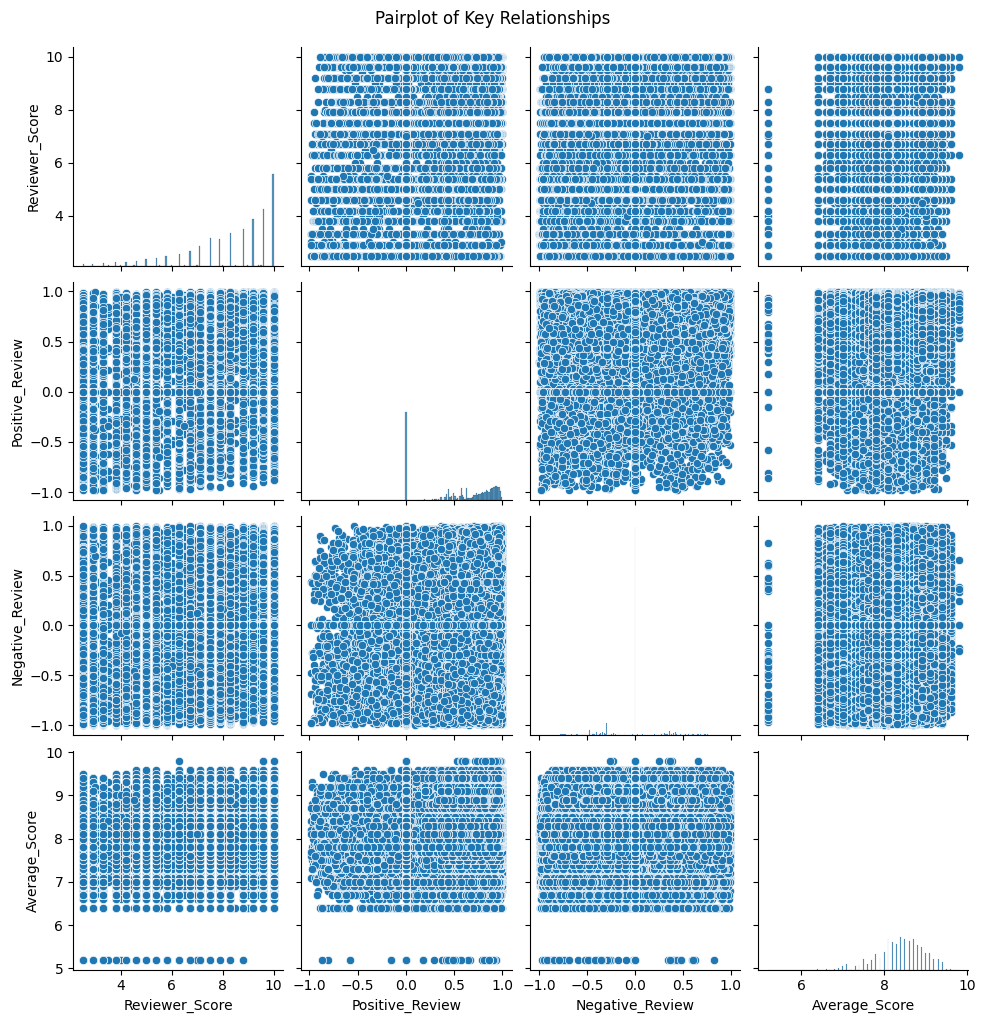

In [20]:
# Pairplot for numeric columns (choose relevant ones for better visualization)
sns.pairplot(df_cleaned[['Reviewer_Score', 'Positive_Review', 'Negative_Review', 'Average_Score']])
plt.suptitle('Pairplot of Key Relationships', y=1.02)
plt.show()


Grouped Analysis:

                Positive_Review  Negative_Review
Reviewer_Score                                  
2.5                   -0.019102        -0.324314
2.9                    0.038508        -0.360883
3.0                   -0.008200        -0.336168
3.1                   -0.195038        -0.373963
3.3                    0.083287        -0.339918
3.5                    0.037938        -0.301704
3.8                    0.108743        -0.329201
4.0                    0.111707        -0.255740
4.2                    0.151538        -0.298934
4.4                    0.049817        -0.375917
4.5                    0.166713        -0.248479
4.6                    0.196643        -0.268466
5.0                    0.234581        -0.233672
5.4                    0.282127        -0.218419
5.5                    0.184804        -0.205937
5.6                    0.164235        -0.283494
5.8                    0.333595        -0.184251
6.0                    0.315773        -0.156135
6.3                 

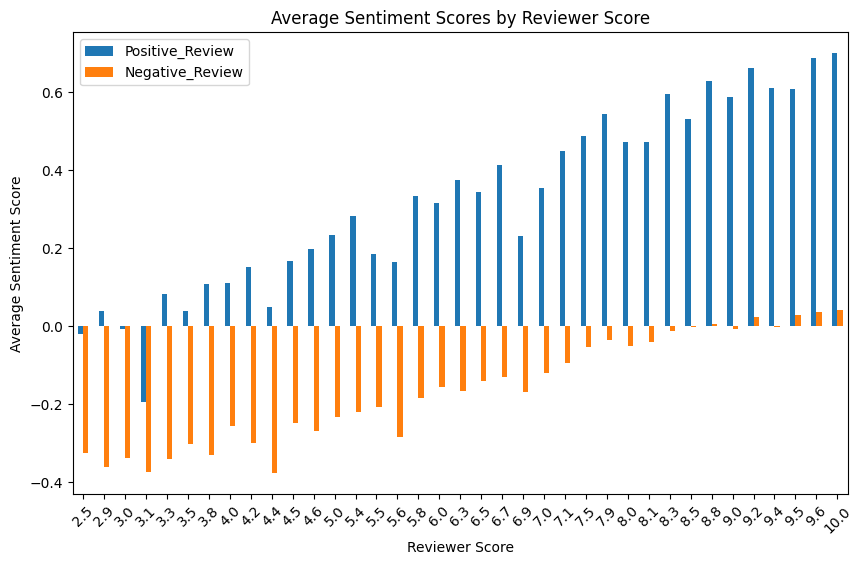

In [21]:
# Group by Reviewer_Score and analyze mean scores
print(df_cleaned.groupby('Reviewer_Score')[['Positive_Review', 'Negative_Review']].mean())

# Visualization for grouped analysis
df_grouped = df_cleaned.groupby('Reviewer_Score').mean()
df_grouped[['Positive_Review', 'Negative_Review']].plot(kind='bar', figsize=(10, 6))

plt.title("Average Sentiment Scores by Reviewer Score")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Reviewer Score")
plt.xticks(rotation=45)
plt.show()


Feature engineering and model training


In [23]:
!pip install optuna


In [24]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.4 MB/s eta 0:00:00


In [25]:
# Imports
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import optuna
import warnings
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv("hotel_reviews_cleaned.csv")

# Subset for efficient training/testing
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

# Feature Selection (text + numerical)
features = [
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Negative_Review',
    'Review_Total_Negative_Word_Counts',
    'Positive_Review',
    'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews_Reviewer_Has_Given'
]

# Label processing
df['Reviewer_Score'] = df['Reviewer_Score'] / 10  # Scale to 0–1

def label_sentiment(score):
    if score < 0.5:
        return 'Negative'
    elif score == 0.5:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Reviewer_Score'].apply(label_sentiment)

# TF-IDF Vectorization
tfidf_neg = TfidfVectorizer(max_features=100)
tfidf_pos = TfidfVectorizer(max_features=100)

neg_tfidf = tfidf_neg.fit_transform(df['Negative_Review'].fillna("").astype(str)).toarray()
pos_tfidf = tfidf_pos.fit_transform(df['Positive_Review'].fillna("").astype(str)).toarray()

neg_tfidf_df = pd.DataFrame(neg_tfidf, columns=[f"neg_{i}" for i in range(neg_tfidf.shape[1])])
pos_tfidf_df = pd.DataFrame(pos_tfidf, columns=[f"pos_{i}" for i in range(pos_tfidf.shape[1])])

# Combine features
numerical_df = df[[
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Review_Total_Negative_Word_Counts',
    'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews_Reviewer_Has_Given'
]].reset_index(drop=True)

X = pd.concat([numerical_df, neg_tfidf_df, pos_tfidf_df], axis=1)
y = df['Sentiment']

# Encode the target
y_encoded = LabelEncoder().fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# ================== Logistic Regression with Optuna ===================

# Store results
results = []

def objective_lr(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])

    model = LogisticRegression(C=C, solver=solver, max_iter=1000)
    return cross_val_score(model, X_train, y_train, cv=2).mean()

# Optimize
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=10)

# Train with best params
best_params = study_lr.best_params
final_model = LogisticRegression(**best_params, max_iter=1000)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Append results
results.append({
    "Model": "Logistic Regression (Bayesian Opt)",
    "Best Params": best_params,
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred, average='weighted')
})

# Define search space
param_dist = {
    'C': uniform(loc=0.01, scale=10),  # Range: 0.01 to 10
    'solver': ['lbfgs', 'liblinear']
}

# logistic regression using random search

# Define model
lr = LogisticRegression(max_iter=1000)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    lr,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=2,
    scoring='accuracy',
    random_state=42,
    verbose=1
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_lr = random_search.best_estimator_

# Predict
y_pred_rs = best_lr.predict(X_test)

# Add result to existing results list
results.append({
    "Model": "Logistic Regression (Random Search)",
    "Best Params": random_search.best_params_,
    "Accuracy": accuracy_score(y_test, y_pred_rs),
    "F1 Score": f1_score(y_test, y_pred_rs, average='weighted')
})

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1.0, 5.0, 10.0],
    'solver': ['lbfgs', 'liblinear']
}

# Create a base Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best model and predictions
best_grid_lr = grid_search.best_estimator_
y_pred_grid = best_grid_lr.predict(X_test)

# Append results
results.append({
    "Model": "Logistic Regression (Grid Search)",
    "Best Params": grid_search.best_params_,
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "F1 Score": f1_score(y_test, y_pred_grid, average='weighted')
})

# Show results
print("\nPerformance Comparison:")
print(pd.DataFrame(results))



[I 2025-08-27 15:12:35,698] A new study created in memory with name: no-name-ab468a09-2649-4f05-9717-e345007fe417
[I 2025-08-27 15:13:39,654] Trial 0 finished with value: 0.9391875000000001 and parameters: {'C': 0.012922034502600646, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9391875000000001.
[I 2025-08-27 15:14:41,841] Trial 1 finished with value: 0.9384375 and parameters: {'C': 5.281033930684339, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9391875000000001.
[I 2025-08-27 15:15:47,713] Trial 2 finished with value: 0.9390000000000001 and parameters: {'C': 0.06732329579837161, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9391875000000001.
[I 2025-08-27 15:16:46,788] Trial 3 finished with value: 0.93925 and parameters: {'C': 0.7183578359747256, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.93925.
[I 2025-08-27 15:17:48,782] Trial 4 finished with value: 0.9394374999999999 and parameters: {'C': 0.6963788585043958, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.939

Fitting 2 folds for each of 10 candidates, totalling 20 fits

Performance Comparison:
                                 Model                                       Best Params  Accuracy  F1 Score
0   Logistic Regression (Bayesian Opt)      {'C': 0.6963788585043958, 'solver': 'lbfgs'}   0.93625  0.912747
1  Logistic Regression (Random Search)  {'C': 0.5741157902710026, 'solver': 'liblinear'}   0.93600  0.912171
2    Logistic Regression (Grid Search)                    {'C': 0.01, 'solver': 'lbfgs'}   0.93750  0.913809


In [26]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import optuna
import warnings
warnings.filterwarnings('ignore')

# === Load Dataset & Create Subset ===
df = pd.read_csv("hotel_reviews_cleaned.csv")
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

# === Feature Engineering ===
df['Reviewer_Score'] = df['Reviewer_Score'] / 10

def label_sentiment(score):
    if score < 0.5:
        return 'Negative'
    elif score == 0.5:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Reviewer_Score'].apply(label_sentiment)

# === TF-IDF Vectorization ===
tfidf_neg = TfidfVectorizer(max_features=100)
tfidf_pos = TfidfVectorizer(max_features=100)

neg_tfidf = tfidf_neg.fit_transform(df['Negative_Review'].fillna("").astype(str)).toarray()
pos_tfidf = tfidf_pos.fit_transform(df['Positive_Review'].fillna("").astype(str)).toarray()

neg_tfidf_df = pd.DataFrame(neg_tfidf, columns=[f"neg_{i}" for i in range(neg_tfidf.shape[1])])
pos_tfidf_df = pd.DataFrame(pos_tfidf, columns=[f"pos_{i}" for i in range(pos_tfidf.shape[1])])

numerical_df = df[[
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Review_Total_Negative_Word_Counts',
    'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews_Reviewer_Has_Given']].reset_index(drop=True)

X = pd.concat([numerical_df, neg_tfidf_df, pos_tfidf_df], axis=1)
y = LabelEncoder().fit_transform(df['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MLPClassifier: Bayesian Optimization ===
def objective_nn(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(100,), (50, 50), (100, 50), (50, 100)])
    activation = trial.suggest_categorical("activation", ['relu', 'tanh'])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=300
    )
    return cross_val_score(clf, X_train, y_train, cv=2).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_nn, n_trials=10)

best_params_bayes = study.best_params
mlp_bayes = MLPClassifier(**best_params_bayes, max_iter=300)
mlp_bayes.fit(X_train, y_train)
y_pred_bayes = mlp_bayes.predict(X_test)

# === MLPClassifier: Random Search ===
param_dist = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50), (50, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
}

mlp_rand = RandomizedSearchCV(MLPClassifier(max_iter=300), param_distributions=param_dist, n_iter=10, cv=2)
mlp_rand.fit(X_train, y_train)
y_pred_rand = mlp_rand.predict(X_test)

# === MLPClassifier: Grid Search ===
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 1e-2]
}

mlp_grid = GridSearchCV(MLPClassifier(max_iter=300), param_grid=param_grid, cv=2)
mlp_grid.fit(X_train, y_train)
y_pred_grid = mlp_grid.predict(X_test)

# === Summary of All Models ===
results = pd.DataFrame([
    {
        "Model": "Neural Network (Bayesian Opt)",
        "Accuracy": accuracy_score(y_test, y_pred_bayes),
        "F1 Score": f1_score(y_test, y_pred_bayes, average='weighted'),
        "Best Params": best_params_bayes
    },
    {
        "Model": "Neural Network (Random Search)",
        "Accuracy": accuracy_score(y_test, y_pred_rand),
        "F1 Score": f1_score(y_test, y_pred_rand, average='weighted'),
        "Best Params": mlp_rand.best_params_
    },
    {
        "Model": "Neural Network (Grid Search)",
        "Accuracy": accuracy_score(y_test, y_pred_grid),
        "F1 Score": f1_score(y_test, y_pred_grid, average='weighted'),
        "Best Params": mlp_grid.best_params_
    }
])

print(results)


[I 2025-08-27 15:28:46,303] A new study created in memory with name: no-name-341bd54f-5121-40e2-950b-69c2c511540b
[I 2025-08-27 15:28:54,272] Trial 0 finished with value: 0.9386875 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'alpha': 0.00824207990380624, 'learning_rate_init': 0.05844796625525744}. Best is trial 0 with value: 0.9386875.
[I 2025-08-27 15:29:09,907] Trial 1 finished with value: 0.93875 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'alpha': 0.01148572137916923, 'learning_rate_init': 0.0072582456460085956}. Best is trial 1 with value: 0.93875.
[I 2025-08-27 15:30:52,147] Trial 2 finished with value: 0.9309375 and parameters: {'hidden_layer_sizes': (50, 100), 'activation': 'tanh', 'alpha': 0.0001619046215079059, 'learning_rate_init': 0.0005876728947616103}. Best is trial 1 with value: 0.93875.
[I 2025-08-27 15:31:02,531] Trial 3 finished with value: 0.9359999999999999 and parameters: {'hidden_layer_sizes': (100,), 'activati

                            Model  Accuracy  F1 Score                                        Best Params
0   Neural Network (Bayesian Opt)   0.93600  0.905058  {'hidden_layer_sizes': (50, 50), 'activation':...
1  Neural Network (Random Search)   0.93625  0.913866  {'learning_rate_init': 0.0001, 'hidden_layer_s...
2    Neural Network (Grid Search)   0.93600  0.905058  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...
